In [2]:
#Basic libraries
import numpy as np
import matplotlib.pyplot as plt

#Importing from UQpy [1] to apply MCMC via Metropolis Hastings :

from UQpy import PythonModel
from UQpy.sampling.mcmc.MetropolisHastings import MetropolisHastings
from UQpy.inference.inference_models.ComputationalModel import ComputationalModel
from UQpy.run_model.RunModel import RunModel
from UQpy.inference import BayesParameterEstimation
from sklearn.neighbors import KernelDensity  # for the plots
from UQpy.distributions import JointIndependent, Normal, Uniform


#For statistics purposes
from scipy import stats as st
from scipy.stats import norm
from scipy.stats import t 
from scipy.optimize import minimize_scalar

from sympy import *

In [4]:
#Defining model system's variables
m,c,k,tt,y0,y0_dot=var('m,c,k,tt,y0,y0_dot')


def y(m,c,k,tt,y0,y0_dot):
    """ 
    This is the model function, that is y=f(q), where q is (are) the parameter(s).
    The function y can return a symbolic expression, being function of the
    corresponding parameters (in this case m,c,k,t,y0 and y0_dot)
    """ 
    # Here, f(q) corresponds to the model defined at Example 2
    wn=sqrt(k/m)          # natural frequency
    zeda=c/(2*sqrt(k*m))  # damping factor
    wd=wn*sqrt(1-zeda**2) # damped natural frequency

    #System's  free response [2]
    #response's amplitude
    Y=sqrt((y0*wn)**2+y0_dot**2+2*zeda*wn*y0*y0_dot)/wd

    #response's phase
    phi=atan(y0*wd/(y0_dot+zeda*wn*y0))

    res=Y*exp(-zeda*wn*tt)*sin(wd*tt+phi)
    
    return res

sc=diff(y(m,c,k,tt,y0,y0_dot), c)

def Dev_y_respect_to_c(m,c,k,tt,y0,y0_dot):
    """ 
    This is the function' derivative respect to c. It is required to
    calculate the sensitiviy matrix. The derivative has been calculated
    symbollicaly, using Sympy.
    
    """ 
    res=m*(2*c*k*m*sqrt(k/m)*((-c**2 + 4*k*m)/(k*m))**(3/2)*(k*y0**2*(c**2 - 4*k*m) - m*(c*y0*sqrt(k/m) + 2*y0_dot*sqrt(k*m))**2)*(c*m*y0*y0_dot*sqrt(k/m) + k*y0**2*sqrt(k*m) + m*y0_dot**2*sqrt(k*m))*sin(tt*sqrt(k/m)*sqrt((-c**2 + 4*k*m)/(k*m))/2 + atan(y0*sqrt(k/m)*sqrt(k*m)*sqrt((-c**2 + 4*k*m)/(k*m))/(c*y0*sqrt(k/m) + 2*y0_dot*sqrt(k*m)))) + k**3*m**2*y0*y0_dot*((-c**2 + 4*k*m)/(k*m))**(5/2)*(k*y0**2*(c**2 - 4*k*m) - m*(c*y0*sqrt(k/m) + 2*y0_dot*sqrt(k*m))**2)*sin(tt*sqrt(k/m)*sqrt((-c**2 + 4*k*m)/(k*m))/2 + atan(y0*sqrt(k/m)*sqrt(k*m)*sqrt((-c**2 + 4*k*m)/(k*m))/(c*y0*sqrt(k/m) + 2*y0_dot*sqrt(k*m)))) - k**2*tt*sqrt(k*m)*((-c**2 + 4*k*m)/(k*m))**(5/2)*(k*y0**2*(c**2 - 4*k*m) - m*(c*y0*sqrt(k/m) + 2*y0_dot*sqrt(k*m))**2)*(c*m*y0*y0_dot*sqrt(k/m) + k*y0**2*sqrt(k*m) + m*y0_dot**2*sqrt(k*m))*sin(tt*sqrt(k/m)*sqrt((-c**2 + 4*k*m)/(k*m))/2 + atan(y0*sqrt(k/m)*sqrt(k*m)*sqrt((-c**2 + 4*k*m)/(k*m))/(c*y0*sqrt(k/m) + 2*y0_dot*sqrt(k*m)))) - sqrt(k/m)*sqrt(k*m)*(-c**2 + 4*k*m)**2*(c*tt*sqrt(k/m)*(k*m)**(3/2)*(k*y0**2*(c**2 - 4*k*m) - m*(c*y0*sqrt(k/m) + 2*y0_dot*sqrt(k*m))**2) - 2*k**2*m**2*y0*(c*m*sqrt(k/m)*(c*y0*sqrt(k/m) + 2*y0_dot*sqrt(k*m)) + k*y0*(-c**2 + 4*k*m)))*(c*m*y0*y0_dot*sqrt(k/m) + k*y0**2*sqrt(k*m) + m*y0_dot**2*sqrt(k*m))*cos(tt*sqrt(k/m)*sqrt((-c**2 + 4*k*m)/(k*m))/2 + atan(y0*sqrt(k/m)*sqrt(k*m)*sqrt((-c**2 + 4*k*m)/(k*m))/(c*y0*sqrt(k/m) + 2*y0_dot*sqrt(k*m))))/(k**3*m**3))*exp(-c*tt*sqrt(k/m)/(2*sqrt(k*m)))/(sqrt(k*m)*sqrt((c*m*y0*y0_dot*sqrt(k/m) + k*y0**2*sqrt(k*m) + m*y0_dot**2*sqrt(k*m))/(m*sqrt(k*m)))*(-c**2 + 4*k*m)**3*(k*y0**2*(c**2 - 4*k*m) - m*(c*y0*sqrt(k/m) + 2*y0_dot*sqrt(k*m))**2)) 
    return res


def Sensitivity_matrix(m_val,c_val,k_val,t_vec,y0_val,y0_dot_val):
    """ 
    This function evaluates the sensitivity matrix [3] asociated to y=f(q)
    It depends on how y() function has been defined above.
    """ 
    n=len(t_vec)  # is the time vector dimension 
    #Calculating symbolic derivatives of f(q)  respect to q parameter
   
    
    
    sens_vec=np.ndarray((n,1))
       
    for i in range(n):    
           
        sc_num=Dev_y_respect_to_c(m_val,c_val,k_val,t_vec[i],y0_val,y0_dot_val)
        sens_vec[i,0]=sc_num
       
       
    res=np.matmul(np.transpose(sens_vec),sens_vec) #Sensitivy matrix [2]
    
    return res
    
# #System's parameter values  [2] 
# #Note: units are assumed since example in ref. [2] does not specified units
# k_val=20.5 #[N/cm]
# m_val=1.0 # [Kg]
# c_val=1.5 # [Ns/cm] <-- used to generate synthetic data

# #initial condition values [2]
# y0_val=2.0       #[cm]
# y0_dot_val=0.0   #[cm/s]

# #Define a time vector to get  system's response and 
# to=0.0 #[s]
# tf=5.0 #[s]
# n=500 #number of points
# t_vec=np.linspace(to, tf,n)

# sigma_error=.1                 # error's standard deviation
# mu_error=0.0                   # error's mean value   
# var_error=sigma_error**2       # error variance



# sen_mat=Sensitivity_matrix(m_val,c_val,k_val,t_vec,y0_val,y0_dot_val)

# V=np.linalg.inv(sen_mat)*var_error                #damping's variance  

In [8]:
#System's parameter values  [2] 
#Note: units are assumed since example in ref. [2] does not specified units
k_true=20.5 #[N/cm]
m_true=1.0 # [Kg]
c_true=1.5 # [Ns/cm] 

#initial condition values [2]
y0_val=2.0       #[cm]
y0_dot_val=0.0   #[cm/s]

#Define a time vector to get  system's response and 
to=0.0 #[s]
tf=5.0 #[s]
n=500 #number of points
t_vec=np.linspace(to, tf,n)


# Defining functions
#_____________________________________________________________________________

#Kernel Density Estimation function
def pdf_from_kde(domain, samples1d):
    bandwidth = 1.06 * np.std(samples1d) * samples1d.size ** (-1 / 5)
    kde = KernelDensity(bandwidth=bandwidth).fit(samples1d.reshape((-1, 1)))
    log_dens = kde.score_samples(domain)
    return np.exp(log_dens)

#_____________________________________________________________________________


# 1 Define noise to be added to sistem´s response. This is a strategy  to 
# generate synthetic data since there are not measurements available

#Assuming that error is iid and error ~ N(error_mu, error_var ) [2]

sigma_error=.1                        # error's standard deviation
error_mu=0.0                          # error's mean value   
error_var=sigma_error**2              # error variance
error=sigma_error*np.random.randn(n)  # errors



#2.System's response "measurements"  
   


# Generate data

param_true = np.array([ c_true,k_true]).reshape((1, -1))


model = PythonModel(model_script='utility_functions.py', model_object_name='y',
                    var_names=['c', 'k'])
h_func = RunModel(model=model)
h_func.run(samples=param_true)
y_vec = np.array(h_func.qoi_list[0]) # Quantity of interest
n_data=len(y_vec)                    # Number of measurements' points

# Add noise, using a random_state for reproducible results
error_covariance = 0.1**2
noise = Normal(loc=0., scale=np.sqrt(error_covariance)).rvs(nsamples=n_data, random_state=123).reshape((n_data,))
#"artificial" measurements
y_obs = y_vec + noise




#MCMC implemented using Metropolis Hastings algorithm

# Prior density matrix

p0 = Normal()
p1 = Normal()
prior = JointIndependent(marginals=[p0, p1])


inference_model = ComputationalModel(n_parameters=2, runmodel_object=h_func, error_covariance=error_covariance,
                                     prior=prior)
# Proposal density J
J = JointIndependent([Normal(scale=0.1), Normal(scale=0.1)])

c_initial=3.0  #Enter here a initial value for the Metropolis-Hastings algoritm (damping coeff)
k_initial=30.0 #Enter here a initial value for the Metropolis-Hastings algoritm (stiffness coeff)

# Invoking Metropolis Hastings algorithm


mh1 = MetropolisHastings(jump=10, burn_length=0, proposal=J, seed=[c_initial, k_initial],
                         random_state=456)

"""
 Info about   some inputs requested by the  Metropolis Hastings algorithm used:
 jump: Thinning parameter, used to reduce correlation between samples. Setting :code:`jump=n` corresponds
 to skipping :code:`n-1` states between accepted states of the chain. Default is :math:`1` (no thinning).
 
 burn_length: number of samples at the beginning of the chain to discard
 
 proposal: Proposal distribution, must have a log_pdf/pdf and rvs method. Default: standard
  multivariate normal
  
 seed: Seed of the Markov chain(s) 
 random_state: Random seed used to initialize the pseudo-random number generator
 (if defined then it wouuld be possible to get same results every time the code runs)
"""



# Bayes estimator
bayes_estimator = BayesParameterEstimation(inference_model=inference_model,
                                           data=y_obs,
                                           sampling_class=mh1,
                                           nsamples=500)

# Finally, samples from estimated distributions for both calculated parameters are:
s = bayes_estimator.sampler.samples

c_bayes_samples=s[:, 0]  # Estimated values samples for dampling coeff.
k_bayes_samples=s[:, 1]  # Estimated values samples for stiffness coeff.

In [14]:
damp_est,a = st.mode(c_bayes_samples)
Sens_matrix_damp=Sensitivity_matrix(m_true,damp_est[0],k_true,t_vec,y0_val,y0_dot_val)
est_error_var_d=np.var(error,ddof=1)
est_error_std_d=np.sqrt(est_error_var_d)
V=np.linalg.inv(Sens_matrix_damp)*est_error_var_d      
SE_d=est_error_std_d*np.sqrt(Sens_matrix_damp)
de = float(damp_est[0])
damp_int=t.interval(alpha = 0.95, df = len(c_bayes_samples) -1, loc = de, scale = float(SE_d))

stiff_est,b = st.mode(k_bayes_samples)
Sens_matrix_stiff=Sensitivity_matrix(m_true,c_true,stiff_est[0],t_vec,y0_val,y0_dot_val)
est_error_var_f=np.var(error,ddof=1)
est_error_std_f=np.sqrt(est_error_var_f)
V=np.linalg.inv(Sens_matrix_stiff)*est_error_var_f      
SE_s=est_error_std_f*np.sqrt(Sens_matrix_stiff)
se = float(stiff_est[0])
stiff_int=t.interval(alpha = 0.95, df = len(k_bayes_samples) -1, loc = se, scale = float(SE_s))

AttributeError: 'numpy.ndarray' object has no attribute 'interval'

NameError: name 'damp_int' is not defined

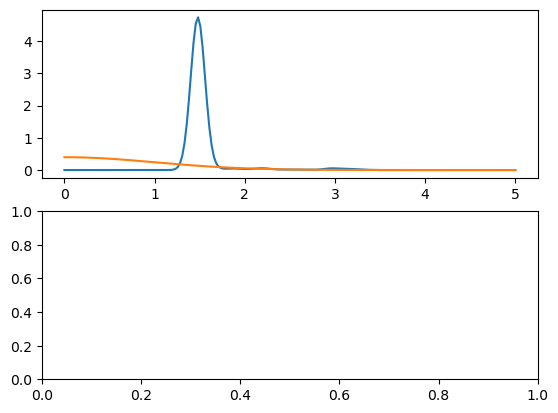

In [15]:
fig, axs=plt.subplots(2,1)
domain_for_c = np.linspace(0, 5, 200)[:, np.newaxis]
pdf_c = pdf_from_kde(domain_for_c,c_bayes_samples )
axs[0].plot(domain_for_c, pdf_c, label='posterior')
axs[0].plot(domain_for_c, p0.pdf(domain_for_c), label='prior')
axs[0].vlines(x=[damp_int[0],damp_int[1]],color='r',ymin=0,ymax=2)
axs[0].set_title('posterior pdf of damping coeff')
axs[0].set_xlabel('c [Ns/cm]')
axs[0].legend()
axs[0].grid(True)

domain_for_k = np.linspace(5, 50, 200)[:, np.newaxis]
pdf_k = pdf_from_kde(domain_for_k, k_bayes_samples)
axs[1].plot(domain_for_k, pdf_k, label='posterior')
axs[1].plot(domain_for_k, p1.pdf(domain_for_k), label='prior')
axs[1].vlines(x=[stiff_int[0],stiff_int[1]],color='r',ymin=0,ymax=0.5)
axs[1].set_title('posterior pdf stiffness coeff')
axs[1].set_xlabel('k [N/cm]')
axs[1].legend()
axs[1].grid(True)

fig.tight_layout()
plt.show()

print('damping',damp_est[0], 'damping interval:',damp_int)
print('stiffness',stiff_est[0], 'stiffness interval:',stiff_int)